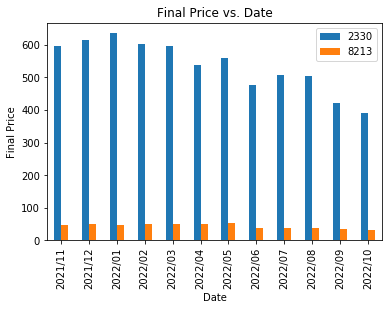

In [5]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from PIL import Image, ImageTk

#設定網路爬蟲與作圖 function web_crawler_and_plot()
def web_crawler_and_plot() :
    
    #讀取輸入框元件內的兩筆輸入股票代碼
    stock_list = stock_entry.get()
    #將股票代碼字串分開並儲存成 stock_id list
    stock_id = list(stock_list.split(','))
    #清除輸入框內容
    stock_entry.delete(0, 'end')
    
    #以迴圈方式,個別爬蟲抓取兩筆股票代碼的資料
    for x in range(0, 2):
        #爬取Goodinfo!台灣股市資訊網站資料
        url = f'https://goodinfo.tw/StockInfo/ShowSaleMonChart.asp?STOCK_ID={stock_id[x]}'
        headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'}
        resp = requests.get(url, headers=headers)
        resp.encoding = 'utf-8'
        raw_html = resp.text
        soup = BeautifulSoup(raw_html, 'html.parser')
        performance_list = []
        #抓取對應股票號碼的時間欄位(近12個月,按照時間順序)與收盤價欄位
        for index in range(16, 4, -1):
          performance_dict = {}
          performance_dict['date'] = soup.select(f'tr:nth-child({index}) > td:nth-child(1) > nobr')[0].text
          performance_dict[f'{stock_id[x]}'] = soup.select(f'tr:nth-child({index}) > td:nth-child(3) > nobr')[0].text
          performance_list.append(performance_dict)
          time.sleep(3)
        
        #將兩筆股票資料(包含日期與每月收盤價)資訊儲存成csv格式檔案
        headers = ['date', f'{stock_id[x]}']
        with open(f'{stock_id[x]}_performance.csv', 'w') as output_file:
          dict_writer = csv.DictWriter(output_file, headers)
          dict_writer.writeheader()
          dict_writer.writerows(performance_list)
    
    #將兩筆csv檔案個別轉成dataframe a & b
    a = pd.read_csv(f'{stock_id[0]}_performance.csv',encoding='utf-8')
    b = pd.read_csv(f'{stock_id[1]}_performance.csv',encoding='utf-8')
    #用merge合併dataframe a & b ,變成單一dataframe data
    data = pd.merge(a,b)
    #將data的date欄位設定成x軸
    data = data.set_index('date')
    #以柱狀圖作圖,x軸為date,y軸為每月收盤價,輸出兩筆股票資訊在同一張圖片data.png
    fig = data.plot(kind='bar').get_figure()
    plt.xlabel('Date')
    plt.ylabel('Final Price')
    plt.title('Final Price vs. Date')
    plt.savefig('data.png', bbox_inches = "tight")
    
    #更新結果標籤元件敘述
    result = '股票號碼：{},{} 近一年每月收盤價圖表如下:'.format(stock_id[0], stock_id[1])
    result_label.configure(text=result)
    
    #把原圖stonks.png替換成股票比較查詢結果data.png
    im = Image.open('data.png')
    image = ImageTk.PhotoImage(im)
    figure_label.configure(image=image)
    figure_label.image=image    

#產生桌面視窗介面    
window = tk.Tk()
window.title('Stock Price Search')
window.geometry('800x600')
window.configure(background='white')

#產生標題股價比較查詢
header_label = tk.Label(window, text='股價比較查詢')
header_label.pack()

#產生輸入股票代碼的輸入框元件
stock_frame = tk.Frame(window)
stock_frame.pack(side=tk.TOP)
stock_label = tk.Label(stock_frame, text='股票號碼')
stock_label.pack(side=tk.LEFT)
stock_entry = tk.Entry(stock_frame)
stock_entry.pack(side=tk.LEFT)

#產生輸入股票代碼說明標籤元件
explanation_label = tk.Label(window)
explanation = '請輸入兩個股票號碼,並以逗點區隔'
explanation_label.configure(text=explanation)
explanation_label.pack()

#產生搜尋按鈕元件,點擊觸發 web_crawler_and_plot function
search_btn = tk.Button(window, text='立即查詢', command=web_crawler_and_plot)
search_btn.pack()

#產生顯示結果標籤元件
result_label = tk.Label(window)
result_label.pack()

#程式執行預設圖片stonks.png
im = Image.open('stonks.png')
image = ImageTk.PhotoImage(im)
figure_label = tk.Label(window,image=image)
figure_label.pack()

#重複刷新tkinter視窗
window.mainloop()